# Advanced exploratory data analysis (EDA) with Python

#### In real world spending enough time on a proper EDA to fully understand your dataset is a key part of any good data science project. As a rule of thumb, you probably will spend 80% of your time in data preparation and exploration and only 20% in actual machine learning modeling.
## Investigation of structure, quality and content
#### Overall, the EDA approach is very iterative. At the end of your investigation you might discover something that will require you to redo everything once more. That is normal! But to impose at least a little bit of structure, I propose the following structure for your investigations:
### 1. Structure investigation: Exploring the general shape of the dataset, as well as the data types of your features.
### 2. Quality investigation: Get a feeling for the general quality of the dataset, with regards to duplicates, missing values and unwanted entries.
### 3. Content investigation: Once thestructure and quality of the dataset is understood, we can go ahead and perform a more in-depth exploration on the features values and look at how different features relates to each other.

#### But first we need to find an interesting dataset. Let's go ahead and load the road safety dataset from OpenML

In [49]:
from sklearn.datasets import fetch_openml

# Download the dataset from openml
dataset = fetch_openml(data_id=42803, as_frame=True)

# Extract feature matrix X and show 5 random samples
df_X = dataset["frame"]

### 1. Structure Investigation
##### Before looking at the content of our feature matrix X, let's first look at the general structure of the dataset. For example, how many columns and rows does the dataset have? And how many different data types do those features include? 

In [50]:
df_X.head()

,Accident_Index,Vehicle_Reference_df_res,Vehicle_Type,Towing_and_Articulation,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,...,Age_Band_of_Casualty,Casualty_Severity,Pedestrian_Location,Pedestrian_Movement,Car_Passenger,Bus_or_Coach_Passenger,Pedestrian_Road_Maintenance_Worker,Casualty_Type,Casualty_Home_Area_Type,Casualty_IMD_Decile
0,201501BS70001,1.0,19.0,0.0,9.0,0.0,8.0,0.0,0.0,0.0,...,7.0,3.0,5.0,1.0,0.0,0.0,2.0,0.0,NaN,NaN
1,201501BS70002,1.0,9.0,0.0,9.0,0.0,8.0,0.0,0.0,0.0,...,5.0,3.0,9.0,9.0,0.0,0.0,2.0,0.0,1.0,3.0
2,201501BS70004,1.0,9.0,0.0,9.0,0.0,2.0,0.0,0.0,0.0,...,6.0,3.0,1.0,3.0,0.0,0.0,2.0,0.0,1.0,6.0
3,201501BS70005,1.0,9.0,0.0,9.0,0.0,2.0,0.0,0.0,0.0,...,2.0,3.0,5.0,1.0,0.0,0.0,2.0,0.0,1.0,2.0
4,201501BS70008,1.0,1.0,0.0,18.0,0.0,8.0,0.0,0.0,0.0,...,8.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0


In [51]:
# Show size of the dataset
df_X.shape

(363243, 67)

In [52]:
import pandas as pd

# Count how many times each data type is present in the dataset
pd.value_counts(df_X.dtypes)

float64    61
object      6
dtype: int64

### 1.1. Structure of non-numerical features
##### Data types can be numerical and non-numerical. First, let's take a closer look at the non-numerical entries

In [60]:
import numpy as np

# get all non numeric columns 
non_numeric_cols = pd.Index(set(df_X.columns).difference(set(df_X.select_dtypes(include=(np.number)).columns)))

In [61]:
non_numeric_cols

Index(['Accident_Index', 'Sex_of_Driver', 'Date', 'Time',
       'LSOA_of_Accident_Location', 'Local_Authority_(Highway)'],
      dtype='object')

In [63]:
# we only want to see the non-numeric features
df_X.describe(exclude="number")

,Accident_Index,Sex_of_Driver,Date,Time,Local_Authority_(Highway),LSOA_of_Accident_Location
count,363243,363243,319866,319822,319866,298758
unique,140056,3,365,1439,204,25979
top,201543P296025,1.0,14/02/2015,17:30,E10000017,E01028497
freq,1332,238639,2144,2972,8457,1456


### 1.2. Structure of numerical features
##### Next, lets take a closer look at the numerical features. More precisely, let's investigate how many unique values each of these feature has. This process will give us some insights about the number of binary (2 unique values), ordinal (3 to ~10 unique values) and continous (more than 10 unique values) features in the dataset.

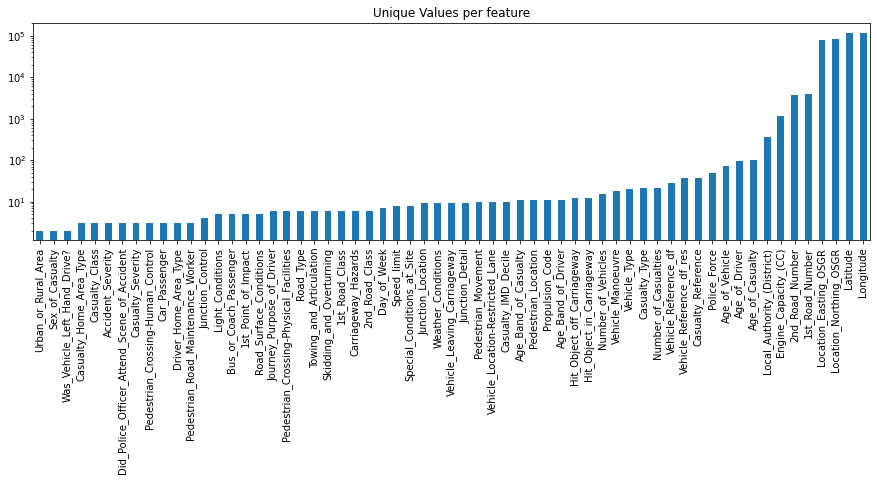

In [41]:
# for each numerical feature compute number of unique entries
unique_values = df_X.select_dtypes(include="number").nunique().sort_values()

# Plot information with y-axis in log-scale
unique_values.plot.bar(logy=True, figsize=(15, 4), title="Unique Values per feature");

### 1.3. Conclusion of structure investigation
##### At the end of this first investigation, we should have a better understanding of the general structure of our dataset. Number of samples and features, what kind of data type each feature has, and how many of them are binary, ordinal, categorical or continuous. For an alternative way to get such kind of information you could also use df_X.info() or df_X.describe().

### 2. Quality Investigation
##### Before focusing on the actual content stored in these features, let's first look at the quality of the dataset. The goal is to have a global view on the dataset with regards to things like duplicates, missing values and unwanted entries or recording errors.

### 2.1. Duplicates
##### Duplicates are entries that represent the same sample point multiples times. For example, if a measurement was registered twice by two different people. Detecting such duplicates is not always easy, as such dataset might have a unique identifier features (e.g. an index number or recording time that is unique to each new sample). So you might want to ignore them first. And once you are aware about the number of duplicates inyour dataset, you can simply drop them with .drop_duplicates().

In [65]:
# Check number of duplicates while ignoring the index feature
n_duplicates = df_X.drop(labels=["Accident_Index"], axis=1).duplicated().sum()
print(f"You seem to have {n_duplicates} duplicates in your database.")

You seem to have 22 duplicates in your database.


In [66]:
# Extract column names of all features, except 'Accident_Index'
columns_to_consider = df_X.drop(labels=["Accident_Index"], axis=1).columns

# Drop duplicates based on 'columns_to_consider'
df_X = df_X.drop_duplicates(subset=columns_to_consider)
df_X.shape

(363221, 67)

### 2.2. Missing Values
##### Another quality issue worth to investigate are missing values. Having some missing values is normal. What we want to identify at this stage are big holes in the dataset, i.e. samples or features with a lot of missing values.
### 2.2.1 Per sample
##### To look at number of missing values per sample we have multiple options. The most straight forward one is to simply visualize the output of df_X.isna(),with something like this:

Text(0, 0.5, 'Sample Number')

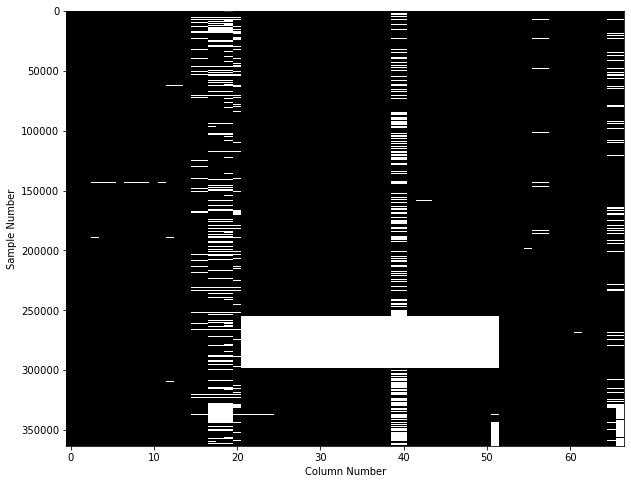

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
plt.imshow(df_X.isna(), aspect="auto", interpolation="nearest",cmap="gray")
plt.xlabel("Column Number")
plt.ylabel("Sample Number")

##### This figure shows on the y-axis each of the 360'000 individual samples, and on the x-axis if any of the 67 features contains a missing value. While this is already a useful plot, an even better approach is to use the missingno library, to get a plot like this one:

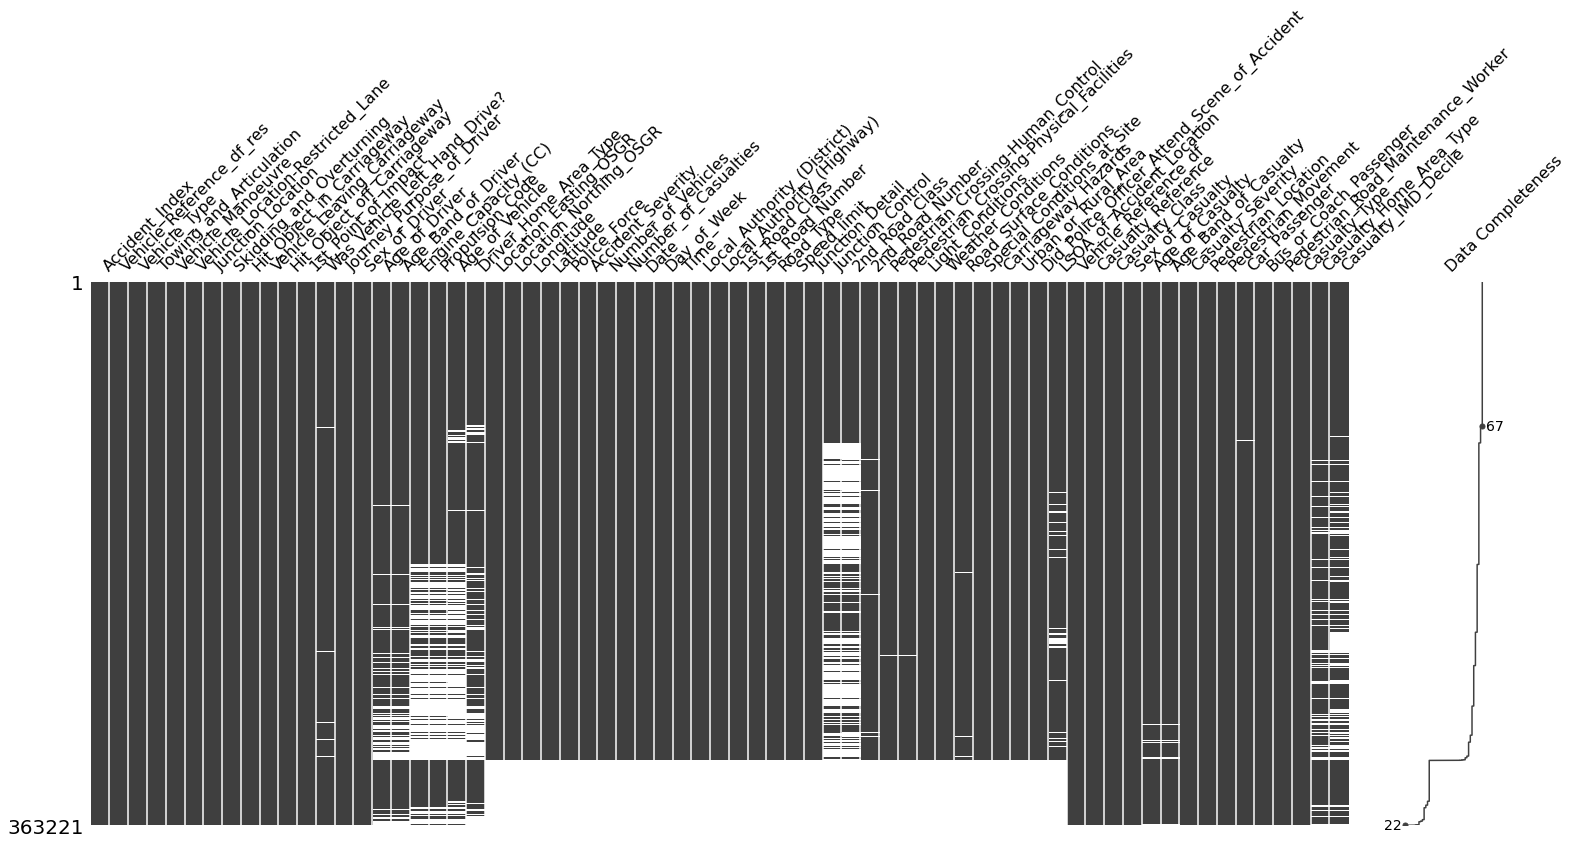

In [68]:
import missingno as msno
msno.matrix(df_X, labels=True, sort="descending");

##### From both of these plots we can see that the dataset has a huge hole, caused by some samples where more than 50% of the feature values are missing. For those samples, filling the missing values with some replacement values is probably not a good idea.
##### Therefore, let's go ahead and drop samples that have more than 20% of missing values. The threshold is inspired by the information from the 'Data Completeness' column on the right of this figure.

In [69]:
df_X = df_X.dropna(thresh=df_X.shape[1] * 0.80, axis=0).reset_index(drop=True)
df_X.shape

(319790, 67)

### 2.2.2. Per Feature
##### As a next step, let's now look at the number of missing values per feature. For this we can use some pandas trickery to quickly identify the ratio of missing values per feature.

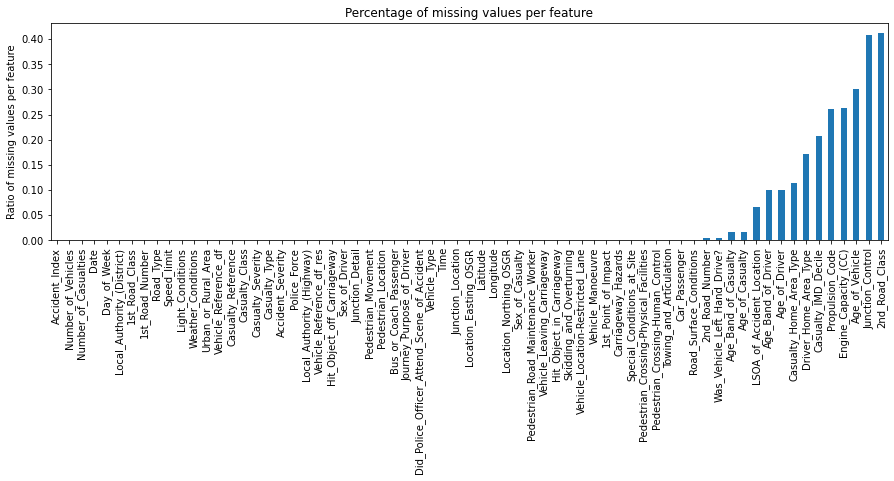

In [70]:
df_X.isna().mean().sort_values().plot(kind="bar", figsize=(15,4), title="Percentage of missing values per feature",
                                     ylabel="Ratio of missing values per feature");

##### From this figure we can see that most features don't contain any missing values. Nonetheless, features like 2nd_Road_Class, Junction_Control, Age_of_Vehicle still contain quite a lot of missing values. So let's go ahead and remove any feature with more than 15% of missing values.

In [71]:
df_X = df_X.dropna(thresh=df_X.shape[0] * 0.85, axis=1)
df_X.shape

(319790, 60)

### 2.2.3. Small side note
##### Missing values: There is no strict order in removing missing values. For some datasets, tackling first the features and than the samples might be better.  Furthermore, the threshold at which you decide to drop missing values per feature of sample changes from dataset, and depends on what you intend to do with the dataset later on.

### 2.3. Unwanted entries and recording errors
##### Another source of quality issues in a dataset can be due to unwanted entries or recording errors. It's important todistinguish such samples from outliers are data points that are unusual for a given features distribution, unwanted entries or recording errors are samples that shouldn't be there in the first place.

### 2.3.1. Numerical features
##### To plot this global view of the dataset, at least for the numerical features, you can use pandas' .plot() function and combine it with the following parameters:
##### . lw=0: lw stands for line width. 0 means that we don't want to show any lines
##### . marker=".": Instead of lines, we tell the plot to use . as markers for each data point
##### . subplots=True: subplots tells pandas to plot each feature in a separate subplot
##### . layout=(-1, 4) : This parameter tells pandas how many rows and columns to use for the subplots. The -1 means " as many as needed", while the 4 means to use 4 columns per row.
##### . figsize=(15, 30), markersize=1 : To make sure that the figure is big enough we recommend to have a figure height of roughly the number of features, and to adjust the markersize accordingly.
#### So what does this plot like?

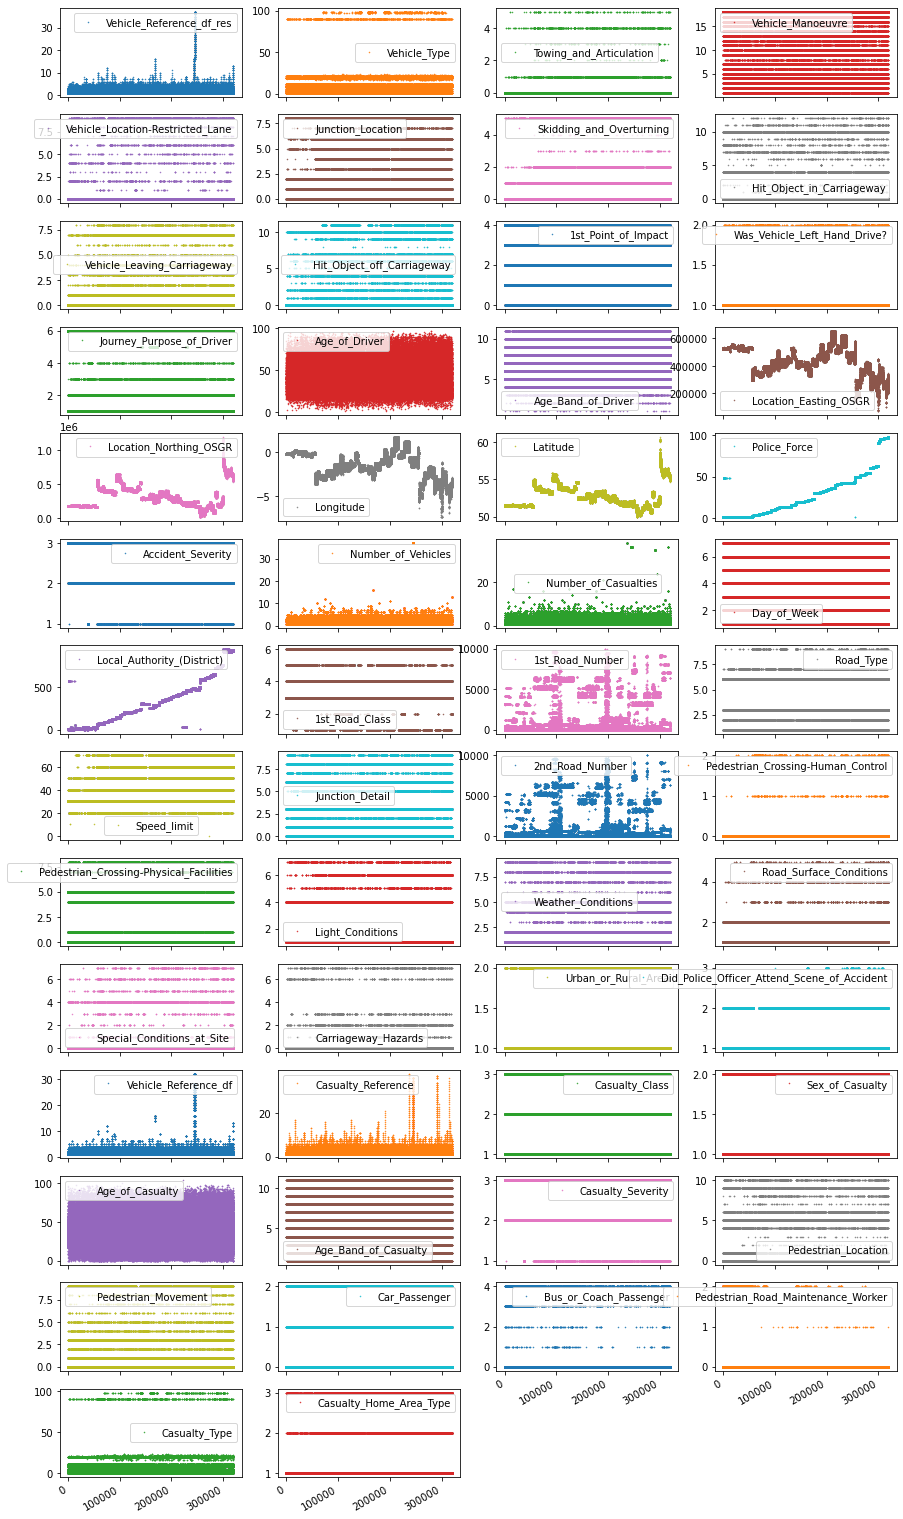

In [72]:
df_X.plot(lw=0,
         marker=".",
         subplots=True,
         layout=(-1, 4),
         figsize=(15, 30),
         markersize=1);

##### Each point in this figure is a sample (i.e. a row) in our dataset and each subplot represents a different feature. The y-axis shows the feature value, while the x-axis is the sample index. These kind of plots can give you a lot of ideas for data cleaning and EDA. Usually it makes sense to invest as much time as needed until you're happy with the output of this visualization.

### 2.3.2. Non-numerical features
##### Identifying unwanted entries or recording errors on non-numerical features is a bit more tricky. Given that at this point, we only want to investigate the general quality of the dataset. So what we can do is take how many unique values each of these non-numerical features contain, and how often their most frequent category is represented. To do so, you can use: df_X.describe(exclude=["number", "datetime"])

In [73]:
non_numeric_df_X = df_X.describe(exclude=["number", "datetime"])

In [74]:
non_numeric_df_X

,Accident_Index,Sex_of_Driver,Date,Time,Local_Authority_(Highway),LSOA_of_Accident_Location
count,319790,319790,319790,319746,319790,298693
unique,123645,3,365,1439,204,25977
top,201543P296025,1.0,14/02/2015,17:30,E10000017,E01028497
freq,1332,211218,2144,2969,8457,1456


##### There are multiple ways for how you could potentially streamline the quality investigation for each individual non-numerical features. None of them is perfect, and all of them will require some follow up investigation. But for the purpose of showcasing one such a solution, what we could do is loop through all non-numerical features and plot for each of them the number of occurrences per unique value.

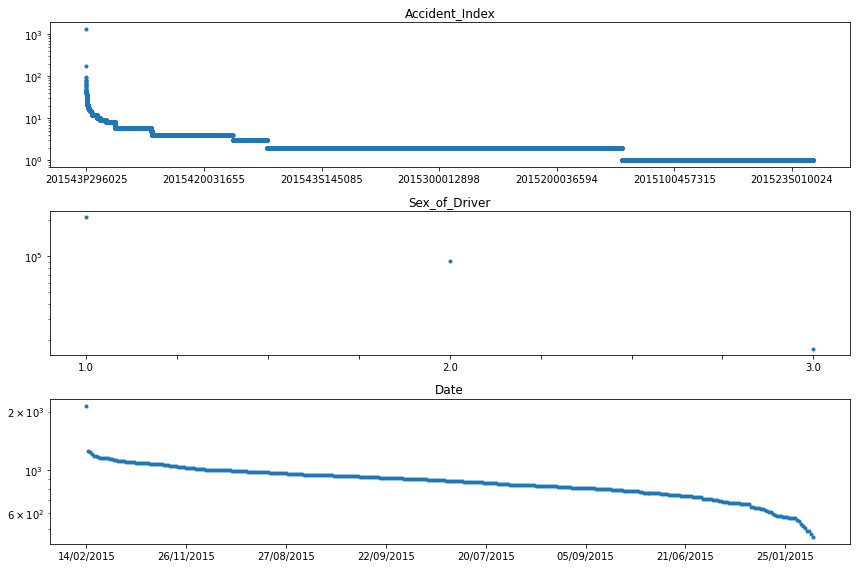

In [75]:
# Create figure object with 3 subplots
fig,axes = plt.subplots(ncols=1, nrows=3, figsize=(12, 8))

# Identify non-numerical features
df_non_numerical = df_X.select_dtypes(exclude=["number", "datetime"])

# Loop through features and put each subplot on a matplotlib axis object
for col, ax in zip(df_non_numerical.columns,
                  axes.ravel()):
    # Selects one single feature and counts number of unique value
    df_non_numerical[col].value_counts().plot(
    # Plots this information in a figure with log-scaled y-axis
    logy=True, title=col, lw=0, marker=".", ax=ax)
plt.tight_layout();

##### We can see that the most frequent accident (i.e. Accident_Index), had more than 100 people involved. Digging a bit deeper (i.e. looking at the individual features of this accident), we could identify that this accident happened on February 24th, 2015 at 11:55 in Cardiff UK. A quick internet search reveals that this entry corresponds to a  luckily non-lethal accident including a minibus full of pensioners.
##### The decision for what should be done with such rather unique entries is once more left in the subjective hands of the person analyzing the dataset. Without any good justification for WHY, and only with the intention to show you the HOW - let's go ahead and remove the 10 most frequent accidents from the dataset.

In [77]:
# Collect entry values of the 10 most frequent accidents
accident_ids = df_non_numerical["Accident_Index"].value_counts().head(10).index

# Removes accidents from the 'accident_ids' list
df_X = df_X[~df_X["Accident_Index"].isin(accident_ids)]
df_X.shape

(317665, 60)

### 2.4. Conclusion of quality investigation
##### At the end of this second investigation, we should have a better understanding of the general quality of our dataset. We looked at duplicates, missing values, and unwanted entries or recording errors. It is important to point out that we didn't discuss yet how to address the remaining missing values or outliers in the dataset.